# 6-2. データの加工
ここでは主にPandasを利用したデータ加工の方法について学ぶ

In [1]:
# 必要なライブラリの読み込み
import pandas as pd
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 4章で利用したMovie Lensを利用

# データセットの読み込み
# ホームページから取得 http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

# ユーザー情報
user_url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_df = pd.read_csv(user_url, sep='|', header=None, encoding='latin-1')
user_col_info = "user id | age | gender | occupation | zip code"
user_df.columns = user_col_info.split(" | ")

# 評価情報
rating_url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
rating_df = pd.read_csv(rating_url, sep='\t', header=None, encoding='latin-1')
rating_col_info = "user id | item id | rating | timestamp"
rating_df.columns = rating_col_info.split(" | ")

## データの結合
評価情報だけ見ても、どのようなユーザーがどの映画に評価をしているのかは分からないため、データを結合することにより良い分析ができる場合がある。

複数のデータ（テーブル）を特定のID（キー）に基づいて繋げることを「結合」と言う。

## 結合の種類
AとBの2つのテーブルがあるときにそれらをキーに基づいて結合する方法は、AをLEFT、Bを RIGHTと表現して以下のような結合の種類がある。

- INNER JOIN ... 両テーブルに同じキーが存在する時に結合
- FULL (OUTER) JOIN ... どちらかにキーが存在すれば結合
- LEFT JOIN ... Aにキーが存在する時に結合
- RIGHT JOIN ... Bにキーが存在する時に結合

In [3]:
# INNER JOINの例
left_table = rating_df.sample(100, random_state=0)
right_table = user_df.sample(500, random_state=0)
merged_df = pd.merge(left_table, right_table, on='user id')
merged_df.head()

,user id,item id,rating,timestamp,age,gender,occupation,zip code
0,23,528,4,874786974,30,F,artist,48197
1,774,28,3,888556698,30,M,student,80027
2,417,550,3,879649178,27,F,other,48103
3,234,1035,3,892335142,60,M,retired,94702
4,586,800,3,884061189,20,M,student,79508


In [4]:
# FULL JOINの例
merged_df = pd.merge(left_table, right_table, on='user id', how='outer')
print(merged_df.shape)
merged_df.head()

(555, 8)


,user id,item id,rating,timestamp,age,gender,occupation,zip code
0,23,528.0,4.0,874786974.0,30.0,F,artist,48197
1,695,242.0,5.0,888805837.0,NaN,NaN,NaN,NaN
2,774,28.0,3.0,888556698.0,30.0,M,student,80027
3,417,550.0,3.0,879649178.0,27.0,F,other,48103
4,234,1035.0,3.0,892335142.0,60.0,M,retired,94702


In [5]:
# LEFT JOINの例
merged_df = pd.merge(left_table, right_table, on='user id', how='left')
print(merged_df.shape)
merged_df.head()

(100, 8)


,user id,item id,rating,timestamp,age,gender,occupation,zip code
0,23,528,4,874786974,30.0,F,artist,48197
1,695,242,5,888805837,NaN,NaN,NaN,NaN
2,774,28,3,888556698,30.0,M,student,80027
3,417,550,3,879649178,27.0,F,other,48103
4,234,1035,3,892335142,60.0,M,retired,94702


In [6]:
# RIGHT JOINの例
merged_df = pd.merge(left_table, right_table, on='user id', how='right')
print(merged_df.shape)
merged_df.head()

(504, 8)


,user id,item id,rating,timestamp,age,gender,occupation,zip code
0,23,528.0,4.0,874786974.0,30,F,artist,48197
1,774,28.0,3.0,888556698.0,30,M,student,80027
2,417,550.0,3.0,879649178.0,27,F,other,48103
3,234,1035.0,3.0,892335142.0,60,M,retired,94702
4,586,800.0,3.0,884061189.0,20,M,student,79508


## データの変換処理
ここではデータ分析でよく用いる2つの処理（マッピング、ビン分割）を紹介する。

In [7]:
# マッピング処理
#   ユーザーデータの性別を日本語にする
gender_map_table = {
    'F': '女性',
    'M': '男性'
}

# map関数を使う
user_df.gender.map(gender_map_table).head()

0    男性
1    女性
2    男性
3    男性
4    女性
Name: gender, dtype: object

In [8]:
# ビン分割
#   年齢を10歳区切りで集計したいなどで活用

# まずは年齢の分布を確認
user_df.age.value_counts().sort_index()[:2], user_df.age.value_counts().sort_index()[-3:]

(7     1
 10    1
 Name: age, dtype: int64, 69    2
 70    3
 73    1
 Name: age, dtype: int64)

In [9]:
# 7歳〜73歳だとわかったので、それをカバーできるように分割
#   意味：0〜10, 10〜20, ... , 70〜80歳の区切りで集計
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_bins_data = pd.cut(user_df.age, age_bins)

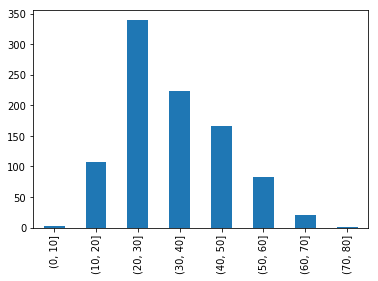

In [10]:
# データの可視化
age_bins_data.value_counts().sort_index().plot(kind='bar')

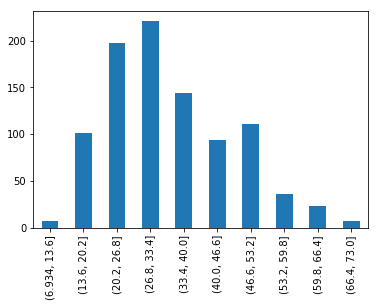

In [11]:
# 区関数を指定して自動分割もできる
age_bins_data = pd.cut(user_df.age, 10)
age_bins_data.value_counts().sort_index().plot(kind='bar')

## 欠損値の扱い
NaNなどで表現される「存在しない」ことを表す欠損値の扱いについて確認する。

### 欠損値
欠損値とは計測や処理の過程で抜け落ちてしまったデータのことで、以下に紹介するような「除外」や「穴埋め」といった方法で対処をすることが多い。

In [12]:
# 欠損値を確認
merged_df = pd.merge(left_table, right_table, on='user id', how='left')
merged_df.head()

,user id,item id,rating,timestamp,age,gender,occupation,zip code
0,23,528,4,874786974,30.0,F,artist,48197
1,695,242,5,888805837,NaN,NaN,NaN,NaN
2,774,28,3,888556698,30.0,M,student,80027
3,417,550,3,879649178,27.0,F,other,48103
4,234,1035,3,892335142,60.0,M,retired,94702


In [13]:
# 欠損値を除外する
#   欠損値を一つでも含む行が除外する
print("全ての行: ", merged_df.shape[0])
print("欠損値を一つでも含む行を除外: ", merged_df.dropna().shape[0])

全ての行:  100
欠損値を一つでも含む行を除外:  49


In [14]:
# 欠損値を穴埋める

# 欠損値を埋める前
print("欠損を含むデータ")
print(merged_df.gender.value_counts())

# 性別データを「"性別データなし"で埋める」
print("\n欠損を補填したデータ")
print(merged_df.gender.fillna("性別データなし").value_counts())

欠損を含むデータ
M    36
F    13
Name: gender, dtype: int64

欠損を補填したデータ
性別データなし    51
M          36
F          13
Name: gender, dtype: int64


In [15]:
# 年齢の欠損値を平均値で埋める
merged_df.age.fillna(merged_df.age.mean()).head()

0    30.000000
1    31.387755
2    30.000000
3    27.000000
4    60.000000
Name: age, dtype: float64